In [1]:
import numpy as np
import symengine as spe
import matplotlib.pyplot as plt
import csv
import sympy
import copy
import torch
from utils import *
import matplotlib as mpl
#mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
t = spe.symbols('t')
example_directory = '../GODE/examples/'
exec(open("../GODE/scipy_solver.py").read())
exec(open("../GODE/loss_function.py").read())
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

# Engineering examples

In [3]:
# Load the data
DATA_TYPE = 'data_noisy'
noise_sigma = 0.05
all_noisy_data = []
all_true_data = []
all_gvae_data = []
all_pysr_data = []
all_pysr2_data = []
all_proged_data = []
num_lode = 0
names = [ 'pendulum', 'duffing_oscillator', 'vanderpol_oscillator']
for i in range(len(names)):
    exec(open(example_directory+names[i]+".py").read())
    print(true_eq)
    true_sol = np.concatenate((t_val, u_val, du_dt_val, d2u_dt2_val), axis = 1)
    all_true_data.append([true_eq, true_sol, ORDER])
    # Extract noisy data
    all_noisy_data.append(d2u_dt2_val_noisy)
    # GVAE result
    curr_loss = 1e6
    curr_eq = ''
    gvae_sol = None
    print('Start GVAE')
    #GVAE Benchmark 3
    with open('GODE_results/Output_B3_n5_'+names[i]+'_GODE.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            _, eq, loss = row
            try:
                curr_sol = solve_implicit_ode(eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                if curr_loss > float(loss):
                    curr_loss = float(loss)
                    curr_eq = eq
                    gvae_sol = curr_sol
            except:
                continue
            k += 1
    all_gvae_data.append([curr_eq, gvae_sol])
    print('End GVAE')
    # PySR results (best)
    curr_loss = 1e6
    curr_eq = ''
    with open('Others_results/PySR/Output_pySR_'+names[i]+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            if float(loss) < curr_loss:
                curr_loss = float(loss)
                curr_eq = eq
            k += 1
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    pysr_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_pysr_data.append([add_on+curr_eq, pysr_sol])
    # ProGED results
    curr_loss = 1e6
    curr_eq = ''
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    with open('Others_results/ProGED/Output_ProGED_'+names[i]+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            eqs = eq.split(',')
            if ORDER == 1:
                eq = eqs[1][:-1].replace('x0', 'u')
            else:
                eq = eqs[2][:-1].replace('x0', 'u')
            eq = eq.replace('x1', 'diff(u,t)')
            try:
                curr_sol = solve_ode(add_on+eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                if float(loss) < curr_loss:
                    curr_loss = float(loss)
                    curr_eq = eq
            except:
                continue
            k += 1
    proged_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_proged_data.append([add_on+curr_eq, proged_sol])
    num_lode += 1

Pendulum
Simulated MSE:  5.856048917160303e-30
Noise level: 0.05
2*diff(diff(u,t),t)+1*diff(u,t)+5*u-2*sin(0.5*t)
Start GVAE
End GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Duffing Oscillator
Simulated MSE:  8.483378602942391e-29
Noise level: 0.05
5*diff(diff(u,t),t)+1*diff(u,t)+7*u+25*u**3-cos(2*t)
Start GVAE
End GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Van der Pol Oscillator
Simulated MSE:  1.5956047383125403e-30
Noise level: 0.05
diff(diff(u,t),t)+5*(1-u^2)*diff(u,t)+u-cos(2*t)
Start GVAE
End GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0


In [4]:
def getR2(true, pred):
    true = np.array(true) # remove last one, as it's included for plotting only
    pred = np.array(pred)
    return 1 - np.sum((true - pred)**2)/np.sum((true - np.mean(true))**2)

def getrelL2Error(true, pred):
    true = np.array(true) # remove last one, as it's included for plotting only
    pred = np.array(pred)
    return np.sqrt(np.sum((true - pred)**2))/np.sqrt(np.sum((true)**2))

In [5]:
# initialise lists
R2_dict = dict()
L2_dict = dict()
label = ['pysr', 'proged','gvae']
for l in label:
    R2_dict[l] = []
    L2_dict[l] = []
# save 1st R2 for u(t), 2nd R2 for u'(t), 3rd R2 for u''(t)

In [6]:
for i in range(len(names)): #10
    print(i)
    true_u = all_true_data[i][1][:,1].flatten()
    true_du = all_true_data[i][1][:,2].flatten()
    if all_true_data[i][2] == 2:
        true_d2u = all_true_data[i][1][:,3].flatten()
    for l in label:
        print(l)
        pred_u = locals()[f"all_{l}_data"][i][1][1].flatten()
        pred_du = locals()[f"all_{l}_data"][i][1][2].flatten()
        if all_true_data[i][2] == 2:
            pred_d2u = locals()[f"all_{l}_data"][i][1][3].flatten()
            R2_dict[l].append([getR2(true_u, pred_u), getR2(true_du, pred_du), getR2(true_d2u, pred_d2u)])
            L2_dict[l].append([getrelL2Error(true_u, pred_u), getrelL2Error(true_du, pred_du), getrelL2Error(true_d2u, pred_d2u)])
        else:
            R2_dict[l].append([getR2(true_u, pred_u), getR2(true_du, pred_du)])
            L2_dict[l].append([getrelL2Error(true_u, pred_u), getrelL2Error(true_du, pred_du)])

0
pysr
proged
gvae
1
pysr
proged
gvae
2
pysr
proged
gvae


In [7]:
for l in label:
    L2_dict[l] = np.array(L2_dict[l])
    R2_dict[l] = np.array(R2_dict[l])

In [8]:
mean_L2_dict = dict()
mean_L2_dict_NLODE = dict()
copy_L2_dict = L2_dict.copy()
for l in label:
    mean_L2_dict[l] = [0,0,0]
    mean_L2_dict_NLODE[l] = [0,0,0]
    for i in range(len(copy_L2_dict[l])):
        copy_L2_dict[l][i] = np.array(copy_L2_dict[l][i])
        copy_L2_dict[l][i][copy_L2_dict[l][i] > 100] = 100
        for j in range(len(copy_L2_dict[l][i])):
            mean_L2_dict[l][j] += copy_L2_dict[l][i][j]
        #if i >= 5:
        #    for j in range(len(copy_L2_dict[l][i])):
        #        mean_L2_dict_NLODE[l][j] += copy_L2_dict[l][i][j]
    mean_L2_dict[l][0] /= 3
    mean_L2_dict[l][1] /= 3
    mean_L2_dict[l][2] /= 3

In [9]:
mean_L2_dict

{'pysr': [5.279978698895302, 1.3497307087936175, 1.3381255700258876],
 'proged': [60.058299118652435, 36.792227045531746, 36.28261515299873],
 'gvae': [0.14880320501666675, 0.09846564659711173, 0.09341713667054681]}

In [10]:
res_selected = [0,1,2]

In [11]:
titles = ['Pendulum', 'Duffing Oscillator','Van der Pol Oscillator']

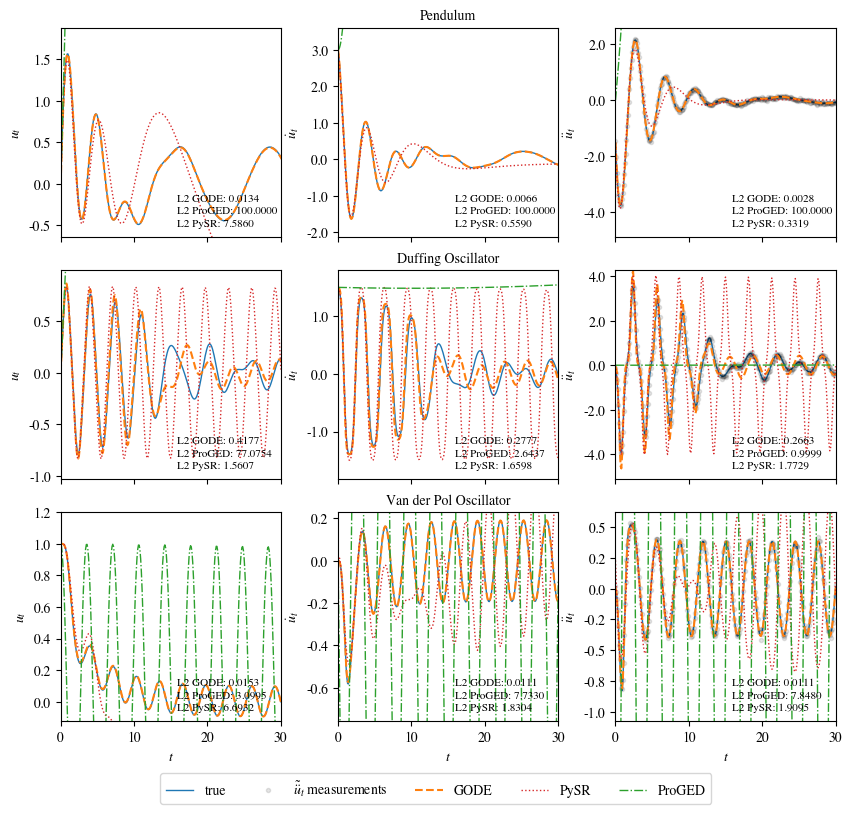

In [12]:
# single results plot
mpl.rc('font', family = 'Times')
mpl.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(len(names),3, figsize=(10,9), sharex= True) #10, 8.5
t = sympy.symbols('t')
for i in range(len(names)):
    order = all_true_data[i][2]
    # true values
    axs[i,0].plot(all_true_data[i][1][:,0], np.array(all_true_data[i][1][:,1]).flatten(), color = 'tab:blue', linewidth = 1, label = '__nolegend__')
    axs[i,1].plot(all_true_data[i][1][:,0], np.array(all_true_data[i][1][:,2]).flatten(), color = 'tab:blue', linewidth = 1, label =  '__nolegend__')
    ylim_min_u = min(np.array(all_true_data[i][1][:,1]).flatten())
    ylim_max_u = max(np.array(all_true_data[i][1][:,1]).flatten())
    ylim_min_du = min(np.array(all_true_data[i][1][:,2]).flatten())
    ylim_max_du = max(np.array(all_true_data[i][1][:,2]).flatten())
    if order == 2:
        axs[i,2].plot(all_true_data[i][1][:,0], np.array(all_true_data[i][1][:,3]).flatten(), color = 'tab:blue', linewidth = 1, label = 'true') #r"$\ddot{u}_t$"
        ylim_min_d2u = min(np.array(all_true_data[i][1][:,3]).flatten())
        ylim_max_d2u = max(np.array(all_true_data[i][1][:,3]).flatten())
        ylim_min_d2u = 1.3*ylim_min_d2u if ylim_min_d2u < 0 else 0.7*ylim_min_d2u
        ylim_max_d2u = 0.8*ylim_max_d2u if ylim_max_d2u < 0 else 1.2*ylim_max_d2u
    ylim_min_u = 1.3*ylim_min_u if ylim_min_u < 0 else 0.7*ylim_min_u
    ylim_max_u = 0.8*ylim_max_u if ylim_max_u < 0 else 1.2*ylim_max_u
    ylim_min_du = 1.3*ylim_min_du if ylim_min_du < 0 else 0.7*ylim_min_du
    ylim_max_du = 0.8*ylim_max_du if ylim_max_du < 0 else 1.2*ylim_max_du
    # measurements
    axs[i,2].plot(all_true_data[i][1][:,0], all_noisy_data[i], '.', alpha = 0.1, color = 'k', label =  r"$\tilde{\ddot{u}}_t$"+' measurements')
    # plot GVAE predictions
    axs[i,0].plot(all_gvae_data[i][1][0], np.array(all_gvae_data[i][1][1]).flatten(), '--', color = 'tab:orange', label ='__nolegend__')
    axs[i,1].plot(all_gvae_data[i][1][0], np.array(all_gvae_data[i][1][2]).flatten(), '--', color = 'tab:orange', label = '__nolegend__')
    if order == 2:
        axs[i,2].plot(all_gvae_data[i][1][0], np.array(all_gvae_data[i][1][3]).flatten(), '--',color = 'tab:orange', label =  'GODE') #r"$\hat{\ddot{u}}_t$" +', 
    # plot PySR predictions
    axs[i,0].plot(all_pysr_data[i][1][0], np.array(all_pysr_data[i][1][1]).flatten(), ':', color = 'tab:red',  linewidth = 1,label = '__nolegend__')
    axs[i,1].plot(all_pysr_data[i][1][0], np.array(all_pysr_data[i][1][2]).flatten(), ':', color = 'tab:red',  linewidth = 1,label = '__nolegend__') 
    if order == 2:
        axs[i,2].plot(all_pysr_data[i][1][0], np.array(all_pysr_data[i][1][3]).flatten(), ':',color = 'tab:red', linewidth = 1, label =  'PySR') #r"$\hat{\ddot{u}}_t$" +', 
    # plot ProGED predictions
    axs[i,0].plot(all_proged_data[i][1][0], np.array(all_proged_data[i][1][1]).flatten(), '-.', color = 'tab:green', linewidth = 1,label =  '__nolegend__')
    axs[i,1].plot(all_proged_data[i][1][0], np.array(all_proged_data[i][1][2]).flatten(), '-.', color = 'tab:green', linewidth = 1,label =  '__nolegend__')
    if order == 2:
        axs[i,2].plot(all_proged_data[i][1][0], np.array(all_proged_data[i][1][3]).flatten(), '-.',color = 'tab:green', linewidth = 1, label = 'ProGED') #r"$\hat{\ddot{u}}_t$" +', """
    # text
    math_expr = all_true_data[i][0][:]
    math_expr = math_expr.replace('^', '**')
    math_expr = math_expr.replace('u', 'u(t)')
    math_expr = sympy.simplify(sympy.sympify(math_expr))
    math_expr = round_expr(math_expr,2)
    math_eq = sympy.latex(math_expr) 
    for j in range(3):
        axs[i,j].text(0.53,0.05,'L2 PySR: {:.4f}'.format(L2_dict['pysr'][i][j]), transform=axs[i,j].transAxes, fontsize = 8)
        axs[i,j].text(0.53,0.11,'L2 ProGED: {:.4f}'.format(L2_dict['proged'][i][j]), transform=axs[i,j].transAxes, fontsize = 8)
        axs[i,j].text(0.53,0.17,'L2 GODE: {:.4f}'.format(L2_dict['gvae'][i][j]), transform=axs[i,j].transAxes, fontsize = 8)
        axs[i,j].set_xlim([0,30])
        axs[len(names)-1,j].set_xlabel(r'$t$', fontsize=10)
    axs[i,0].set_ylim([ylim_min_u, ylim_max_u])
    axs[i,1].set_ylim([ylim_min_du, ylim_max_du])
    axs[i,2].set_ylim([ylim_min_d2u, ylim_max_d2u])
    #axs[i].set_title(titles[i]+f": ${math_eq}$", fontsize=10)
    #plt.xlabel('t', fontsize = 10)
    axs[i,0].set_ylabel(r'$u_t$', fontsize=10)
    axs[i,1].set_ylabel(r'$\dot{u}_t$', fontsize=10)
    axs[i,2].set_ylabel(r'$\ddot{u}_t$', fontsize=10)
    axs[i,1].set_title(titles[i], fontsize=10)
    axs[i,0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[i,1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[i,2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
handles, labels = axs[0,2].get_legend_handles_labels()
idx_order = [0,1,2,3,4]
fig.legend([handles[ind] for ind in idx_order],[labels[ind] for ind in idx_order],loc='lower center', bbox_to_anchor=(0.5, 0.01), ncols = 5, fontsize = 10)
plt.subplots_adjust(hspace=0.16, wspace = 0.26)
#plt.savefig('B3_Solution_Trajectories_Comparison.png', dpi = 600, bbox_inches = 'tight')

In [13]:
# Check complexity of all expressions
all_equations_tree = dict()
all_equations = dict()
all_complexity = dict()
label = ['true', 'pysr','proged','gvae']
for l in label:
    all_equations_tree[l] = []
    all_equations[l] = []
    all_complexity[l] = []

In [14]:
weights = {
    "constant": 1,   # Weight for constants
    "variable": 1,   # Weight for variables
    "operation": 1,  # Weight for operations
}
def compute_complexity(expr):
    if expr.is_Atom:  # Leaf nodes
        if expr.is_Number:
            return weights["constant"]
        elif expr.is_Symbol:
            return weights["variable"]
    # Operations or composite expressions
    return weights["operation"] + sum(compute_complexity(arg) for arg in expr.args)

In [15]:
for i in range(0,3):
    for l in label:
        eq = locals()[f"all_{l}_data"][i][0]
        eq = eq.replace('u', 'u(t)')
        if l == 'gvae':
            expr = eq.replace('diff(diff(u(t),t),t)', 'd2u_dt2')
            expr = expr.replace('diff(u(t),t)', 'du_dt')
            expr = expr.replace('u(t)', 'u_t')
            eq = spe.sympify(expr).expand()#normalize_expr()
            eq = eq.replace('u_t', 'u(t)')
            eq = eq.replace('du_dt', 'Derivative(u,t)')
            eq = eq.replace('d2u_dt2', 'Derivative(Derivative(u,t),t)')
        eq = sympy.sympify(eq)
        eq = sympy.simplify(eq)
        all_equations_tree[l].append(sympy.srepr(eq))
        all_equations[l].append(str(eq))
        all_complexity[l].append(compute_complexity(eq))

In [16]:
for l in label:
    print(f"Mean complexity of {l} equations: {np.mean(np.array(all_complexity[l]))}")
    print(f"Mean normalized complexity of {l} equations: {np.mean(np.array(all_complexity[l]/np.array(all_complexity['true'])))}")

Mean complexity of true equations: 28.333333333333332
Mean normalized complexity of true equations: 1.0
Mean complexity of pysr equations: 28.0
Mean normalized complexity of pysr equations: 1.0073414905450502
Mean complexity of proged equations: 15.666666666666666
Mean normalized complexity of proged equations: 0.5508194289951799
Mean complexity of gvae equations: 29.333333333333332
Mean normalized complexity of gvae equations: 1.0322877271041897


In [17]:
# Display all expressions
all_equations_tree = dict()
all_equations = dict()
gvae_simplified = []
for l in label:
    all_equations[l] = []
for i in range(len(names)):
    for l in label:
        eq = locals()[f"all_{l}_data"][i][0]
        all_equations[l].append(eq)
        if l == 'gvae':
            eq = eq.replace('u', 'u(t)')
            eq = eq.replace('diff', 'Derivative')
            eq = sympy.sympify(eq)
            eq = sympy.simplify(eq)
            eq = str(eq).replace('u(t)','u')
            eq = eq.replace('Derivative','diff')
            gvae_simplified.append(eq)

In [18]:
for i in range(len(names)):
    print('##################')
    print('True:', all_equations['true'][i])
    print('ProGED:', all_equations['proged'][i])
    print('PySR:', all_equations['pysr'][i])
    print('GVAE:', gvae_simplified[i])

##################
True: 2*diff(diff(u,t),t)+1*diff(u,t)+5*u-2*sin(0.5*t)
ProGED: -diff(diff(u,t),t)+ u
PySR: -diff(diff(u,t),t)+(cos(0.772393) ^ t) * (((-3.2377396 - t) * u) - (diff(u,t) + -1.4636616))
GVAE: 5.0842859897430125*u - 2.0*sin(0.5*t) + 1.0210529535220143*diff(u, t) + 2.0342300139776937*diff(u, (t, 2))
##################
True: 5*diff(diff(u,t),t)+1*diff(u,t)+7*u+25*u**3-cos(2*t)
ProGED: -diff(diff(u,t),t)+ 0.000297712922115784*t - 0.00303709549036662
PySR: -diff(diff(u,t),t)+(sin(u) * 29.03376) - (u * 30.66533)
GVAE: 17.8839598712145*u**3 + 0.43613941358847463*u - cos(2*t) + 0.7770001698710407*diff(u, t) + 2.4955361997130385*diff(u, (t, 2))
##################
True: diff(diff(u,t),t)+5*(1-u^2)*diff(u,t)+u-cos(2*t)
ProGED: -diff(diff(u,t),t)+ -3.14237275150241*u*cos(u**2) - u - 0.0487514657778415
PySR: -diff(diff(u,t),t)+sin((-0.7095345 - u) * (sin(t + -0.13705398) * (((0.5595476 ^ t) * diff(u,t)) + cos(t + -0.10962296))))
GVAE: -4.867408964912455*u**2*cos(0.00032300578217798